# Eercise 6 - Elektrisches Modell
In this exercise, you will extend the Model class in the Simulation.py from a purely thermal model to also include electric energy flows, namely the PV and a simple heating/cooling system with a heat pump.

To do this, you need to do the following steps:
* Change the Model ``_init__()`` to 
   * include a PV instance        
   * and numpy arrays for the PV energy flows (``PV_prod, PV_use, PV_feedin``) 
       * Make sure to convert the ``PV.TSD`` to the appropriate units, make sure to also do this every time, the simulation initializes:
       * ``self.PV_prod = self.PV.TSD */ ... # convert to Wh/m² like all other flows in the model``
   * Add numpy arrays for the electricity demands:
       * ``ED_user`` = column "Nutzerstrom_W_m2" from already initialized usage_profiles dataframe,
       * ``ED_QH`` to store the electricty demand of the heat pump for heating
       * ``ED_QC`` for cooling
       * ``ED`` to store the total electricity demand
       * ``ED_grid`` remaining demand supplied by the grid
       



## Update Simulation 

Add the following calls to your simulation method:
````
            #calc total energy demand
            self.calc_ED(t)

            #allocate pv
            self.handle_PV(t)
            
            # handle grid
            self.handle_grid(t)
````

## Heating/cooling 
Before you can actually implement these new calculation and handling methods, you need to include additional parameters, either in a second class called HVAC in the Models.py, or directly in the ``Simulation.__init__()``. I strongly suggest creating a new class for this so as to "separate concerns".  As a first start, use the following parameters to calculate the heat pump electricity from the heating and cooling demand with a simple linear model:
````
class HVAC:
    """HVAC parameters"""
    heating_system = True
    heating_months = [1,2,3,4,9,10,11,12] # specify which months should the heating be useed
    minimum_room_temperature = 20.

    HP_COP = 5 # use this static cop to calc ED = QH / cop
    HP_heating_power = 20 #W/m² however, electric heating power cannot exceed this
    heating_eff = 0.95  # Wirkungsgrad Verteilverluste: 
                        # fraction of HP heat generation reaching the room 
                        # to supply heat demand

    cooling_system = True
    cooling_months = [4,5,6,7,8,9]
    maximum_room_temperature = 26.

    #DHW_COP = 3 
````
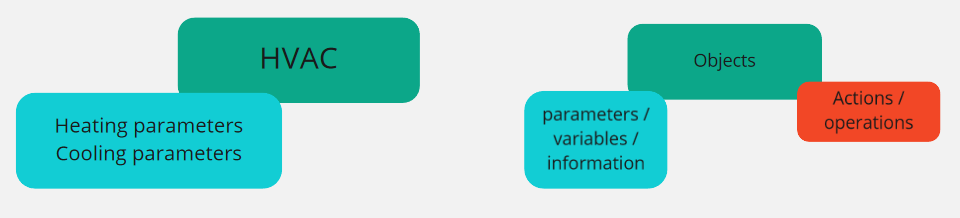


## Update Handling and calculation methods
Add the calculation and handling methods and add the ED_QH and ED_QC in the handling methods for heating and cooling:
````
# in Model class:
    def calc_ED(self, t):
        # calc ED
        ...
    
    def handle_heating(self,t):
        ...
        # calc ED_QH requirements from QH
        # check that requirements dont exceed the HP max power
        # determine actual ED_QH
            # if its below the required, you also need to reduce QH accordingly 
             
    def handle_cooling(self,t):
        ...
        # add calculation for ED_QC
        # same with heating
        
    def handle_PV(self, t):
        # self.PV_use[t] = ...
        # self.PV_feedin[t] = ...
        
    def handle_grid(self, t):
        # self.ED_grid[t] = ... calculate the remaining grid demand
````


## Plots
Finally, Add an additional plotting method called ``plot_electricity_use`` in the Model class like in the previous exercise to plot the energy use of PV as a stacked area: PV_use, ED_grid, PV_feedin

## Test the extended model
You should now be able to use the model like this:


In [1]:
from Simulation import Model

test = Model()
test

initializing Building object from ..\..\data\building_oib_16linie.xlsx



Gebäude    ..\..\data\building_oib_16linie.xlsx
PV-Anlage  1 kWp
Batterie   1 kWh
--- self.simulated=False ------------------------


In [2]:
from Building import Building
ph = Building("../../data/building_ph.xlsx")
ph.LT


initializing Building object from ../../data/building_ph.xlsx


0.4190321758930481

In [3]:
test.building.LT

0.4617385780320856

In [4]:
test.building = ph
test.building.LT

0.4190321758930481

In [5]:
test.simulate()

True

In [6]:
test.QH.sum() # Wh/a/m²

21071.150011652637

In [7]:
test.ED_QH.sum() /1000 #Electric Heating demand kWh/m²

4.436031581400555

In [8]:
test.timestamp

0      2021-01-01 00:00:00
1      2021-01-01 01:00:00
2      2021-01-01 02:00:00
3      2021-01-01 03:00:00
4      2021-01-01 04:00:00
               ...        
8755   2021-12-31 19:00:00
8756   2021-12-31 20:00:00
8757   2021-12-31 21:00:00
8758   2021-12-31 22:00:00
8759   2021-12-31 23:00:00
Length: 8760, dtype: datetime64[ns]

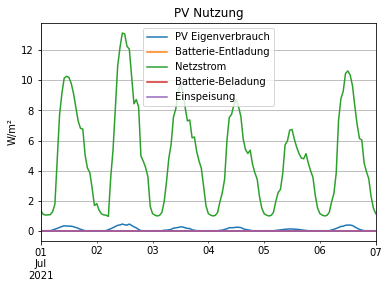

In [9]:
test.plot_electricity_use(start="2021-07-01 00:00:00", end="2021-07-07 00:00:00") 
#use 2 summerweeks in the middle of the year (hours 4000-4300) to actually see something

In [10]:
# not much going on, PV seems a little small
test.PV.kWp, test.PV_use.sum()/1000 # kWh/m²

(1, 0.7210744010416666)

In [11]:
# change the kWp of the PV and run the simulation again
test.PV.set_kWp(60)
test.PV.kWp, test.PV_use.sum()/1000 # kWh/m²

(60, 0.7210744010416666)

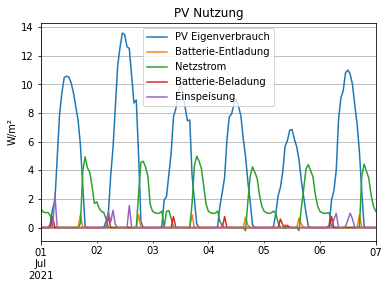

In [12]:
test.simulate()
test.plot_electricity_use(start="2021-07-01 00:00:00", end="2021-07-07 00:00:00") 

In [13]:
# much better!
# if you dont see a change in simulation here after you rescaled the PV system, 
# have a look at where you calculate self.PV_prod from the self.PV.TSD.
# where should it change to reflect the new PV.kWp?b

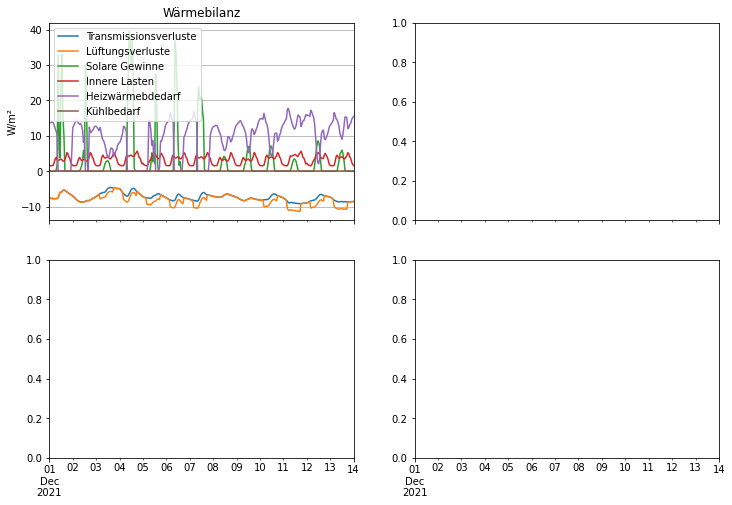

C:\Users\Simon\PycharmProjects\MEE1-3-PEQ\Exercises\solutions\Simulation.py:314: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


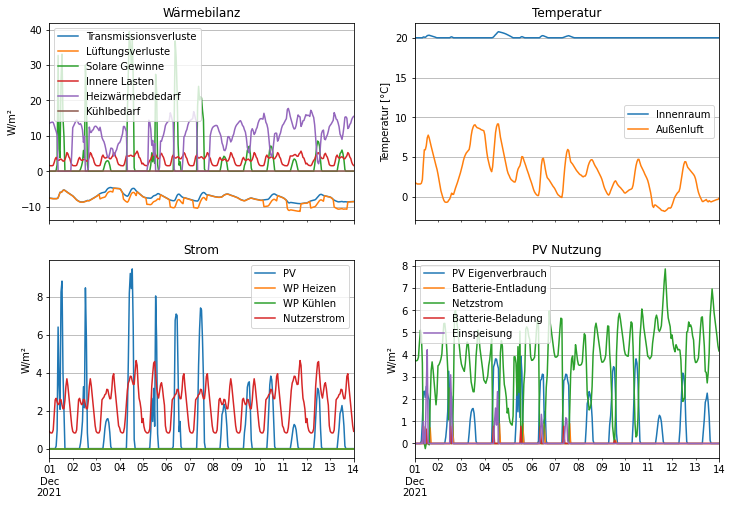

In [16]:
# let's have a look at all results in winter
test.plot(start="2021-12-01 00:00:00", end="2021-12-14 00:00:00");